# Analyze cell-gene matrix
This Python Jupyter notebook processes the cell-gene matrix for basic purposes such as removing doublets and examining the amount of viral products per cell.

## Parameters
First, set the parameters for the notebook, such as to specify the input files and output plots.
This is done in the next cell, which is tagged as a `parameters` cell to enable [papermill parameterization](https://papermill.readthedocs.io/en/latest/usage-parameterize.html):

In [1]:
# parameters cell; in order for notebook to run this cell must define:
#  - input_matrix: filtered gene-barcode matrix from `STARsolo`
#  - input_features: list of features (genes) from `STARsolo`
#  - input_barcodes: list of cell barcodes from `STARsolo`
#  - input_viral_gtf: GTF file giving names of viral genes
#  - input_viraltag_counts: CSV file giving counts of viral variant tags, parsed by `viraltag_count` notebook
#  - input_viralbc_counts: CSV file giving counts of viral barcodes, parsed by `viraltag_count` notebook

In [2]:
# Parameters
input_matrix = "results/aligned_fastq10x/hashing_trial2/Solo.out/Gene/filtered/matrix.mtx"
input_features = "results/aligned_fastq10x/hashing_trial2/Solo.out/Gene/filtered/features.tsv"
input_barcodes = "results/aligned_fastq10x/hashing_trial2/Solo.out/Gene/filtered/barcodes.tsv"
input_viral_gtf = "data/flu_sequences/flu-CA09.gtf"
input_viraltag_counts = "results/viral_fastq10x/viraltag_counts_hashing_trial2.csv"
input_viralbc_counts = "results/viral_fastq10x/viralbc_counts_hashing_trial2.csv"

## Import Python modules
We use [anndata](https://anndata.readthedocs.io/) and [scanpy](https://scanpy.readthedocs.io/) for most the data processing, and [plotnine](https://plotnine.readthedocs.io/) for ggplot2-style plotting:

In [3]:
import os

import anndata
import BCBio.GFF
from IPython.display import display, HTML
import numpy
import math
from scipy.stats import poisson
import pandas as pd
from plotnine import *
import scanpy as sc

Set [scanpy](https://scanpy.readthedocs.io/) to provide lots of information including hints:

In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

Versions of key [scanpy](https://scanpy.readthedocs.io/) packages:

In [5]:
sc.logging.print_versions()

scanpy==1.4.6 anndata==0.7.1 umap==0.3.10 numpy==1.17.0 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.1


Color-blind palette:

In [6]:
cbpalette = ('#999999', '#E69F00', '#56B4E9', '#009E73',
             '#F0E442', '#0072B2', '#D55E00', '#CC79A7')

Set [plotnine theme](https://plotnine.readthedocs.io/en/stable/api.html#themes):

In [7]:
_ = theme_set(theme_classic)

## Read the cell-gene matrix
Read the cell-gene matrix into an [AnnData](https://anndata.readthedocs.io/) annotated data object.
We can't _quite_ use the [scanpy read_10x_mtx](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.api.read_10x_mtx.html) function as the `STARsolo` output isn't in quite the write format, so instead we write our own code that accomplishes the same:

In [8]:
print(f"Reading cell-gene matrix from {input_matrix}")
adata = anndata.read_mtx(input_matrix).T

print(f"Reading features (genes) from {input_features}")
genes = pd.read_csv(input_features, header=None, sep='\t')
adata.var_names = (anndata.utils.make_index_unique(pd.Index(genes[1]))
                   .rename('gene_symbols')
                   )
adata.var['gene_ids'] = genes[0].values

print(f"Reading barcodes (cells) from {input_barcodes}")
cells = pd.read_csv(input_barcodes, header=None, sep='\t')[0]
adata.obs_names = cells.rename('cell_barcodes')

print(f"\nInfo on created annotated data object:\n{adata}")

Reading cell-gene matrix from results/aligned_fastq10x/hashing_trial2/Solo.out/Gene/filtered/matrix.mtx
Reading features (genes) from results/aligned_fastq10x/hashing_trial2/Solo.out/Gene/filtered/features.tsv
Reading barcodes (cells) from results/aligned_fastq10x/hashing_trial2/Solo.out/Gene/filtered/barcodes.tsv

Info on created annotated data object:
AnnData object with n_obs × n_vars = 3737 × 30959 
    var: 'gene_ids'


## Basic analysis of total and viral UMIs per cell

### Total UMIs per cell
Annotate and plot total UMIs per cell:

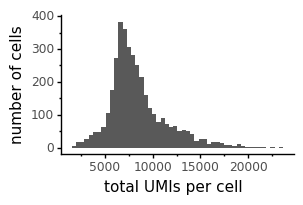

In [9]:
adata.obs['total_UMIs'] = numpy.sum(adata.X, axis=1).A1

p = (ggplot(adata.obs, aes('total_UMIs')) +
     geom_histogram(bins=50) +
     theme(figure_size=(3, 1.8)) +
     xlab('total UMIs per cell') +
     ylab('number of cells')
     )
_ = p.draw()

### Viral UMIs per cell
First get the viral transcripts:

In [10]:
print(f"Reading names of viral transcripts from {input_viral_gtf}")
with open(input_viral_gtf) as f:
    viral_genes = [seqrecord.id for seqrecord in BCBio.GFF.parse(f)]
    
print('The viral transcripts are as follows:\n\t' + '\n\t'.join(viral_genes))

assert set(viral_genes) <= set(adata.var_names), "missing some viral genes"

Reading names of viral transcripts from data/flu_sequences/flu-CA09.gtf
The viral transcripts are as follows:
	fluHA
	fluM
	fluNA
	fluNP
	fluNS
	fluPA
	fluPB1
	fluPB2


Now annotate and plot total viral UMIs per cell:

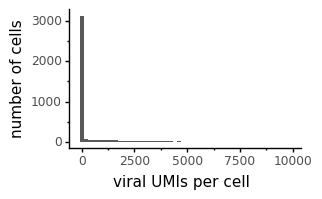

In [11]:
adata.obs['viral_UMIs'] = numpy.sum(adata[:, viral_genes].X, axis=1).A1

p = (ggplot(adata.obs, aes('viral_UMIs')) +
     geom_histogram(bins=50) +
     theme(figure_size=(3, 1.8)) +
     xlab('viral UMIs per cell') +
     ylab('number of cells')
     )
_ = p.draw()

Also annotate total cellular (non viral) UMIs per cell:

In [12]:
adata.obs['cellular_UMIs'] = adata.obs['total_UMIs'] - adata.obs['viral_UMIs']

And annotate the fraction of UMIs that are viral:

In [13]:
adata.obs['viral_UMI_frac'] = adata.obs['viral_UMIs'] / adata.obs['total_UMIs']

### Bulk Metrics of Viral Load
Want to know how many reads are coming from virus, rather than host, in this datset overall.

In [14]:
bulk_viral_UMIs = adata.obs['viral_UMIs'].sum()
bulk_cellular_UMIs = adata.obs['cellular_UMIs'].sum()
bulk_total_UMIs = adata.obs['total_UMIs'].sum()
assert bulk_total_UMIs == bulk_viral_UMIs + bulk_cellular_UMIs, "Error calculating bulk metrics."

print(f"The total fraction of viral UMIs in this dataset is: {bulk_viral_UMIs/bulk_total_UMIs:.3f}")

high_virus_cells = adata.obs.query('viral_UMI_frac > 0.1')
print(f"\nThere are {len(high_virus_cells)} unfiltered cells with a high viral burden (more than 10% of UMIs come from virus).")
print(f"In these cells, the average proportion of UMIs from virus is: {high_virus_cells['viral_UMI_frac'].mean():.3f}")

The total fraction of viral UMIs in this dataset is: 0.034

There are 386 unfiltered cells with a high viral burden (more than 10% of UMIs come from virus).
In these cells, the average proportion of UMIs from virus is: 0.301


### Correlation between viral and total/cellular UMIs
Below calculate the correlation between the viral and total and cellular mRNAs:

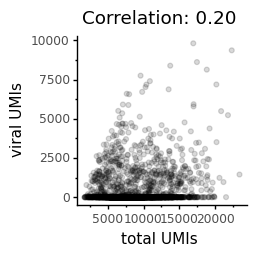

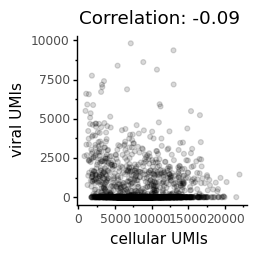

In [15]:
for x in ['total_UMIs', 'cellular_UMIs']:
    
    corr = adata.obs[x].corr(adata.obs['viral_UMIs'], method='pearson')
    
    p = (ggplot(adata.obs, aes(x, 'viral_UMIs')) +
         geom_point(alpha=0.15) +
         theme(figure_size=(2.2, 2.2)) +
         xlab(x.replace('_', ' ')) +
         ylab('viral UMIs') +
         ggtitle(f"Correlation: {corr:.2f}")
         )
    _ = p.draw()

### Filter cells on total cellular UMIs
We filter cells that have unusually low or high number of UMIs.
We mark as `filtered` cells that fail the filter:

In [16]:
mean_cell_UMIs = adata.obs['cellular_UMIs'].mean()
limits = (mean_cell_UMIs / 2.5, mean_cell_UMIs * 2.5)

print(f"Average of {mean_cell_UMIs:.1f} cellular UMIs / cell.\nMarking as "
      f"filtered if <{limits[0]:.1f} or >{limits[1]:.1f} cellular UMIs.")

adata.obs = (
    adata.obs
    .assign(filtered=lambda x: ((x['cellular_UMIs'] < limits[0]) |
                                (x['cellular_UMIs'] > limits[1])),
            filtered_desc=lambda x: numpy.where(x['filtered'] != True, 'retained',
                                    numpy.where(x['cellular_UMIs'] < limits[0],
                                    'too few cellular UMIs', 'too many cellular UMIs')),
            )
    )

Average of 8116.0 cellular UMIs / cell.
Marking as filtered if <3246.4 or >20290.1 cellular UMIs.


Plot cellular and viral mRNAs in filtered versus retained cells

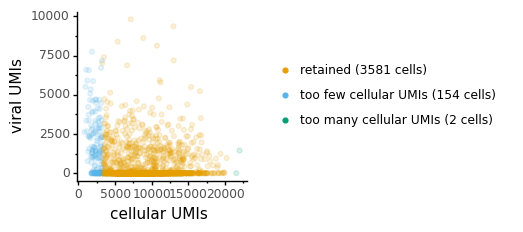

In [17]:
p = (ggplot(
        adata.obs.assign(ncells=lambda x: x.groupby('filtered_desc')
                                           ['filtered']
                                           .transform('count'),
                         cell_group=lambda x: x['filtered_desc'] + ' (' + 
                                              x['ncells'].astype(str) + ' cells)'
                         ),
        aes('cellular_UMIs', 'viral_UMIs', color='cell_group')) +
     geom_point(alpha=0.15) +
     theme(figure_size=(2.2, 2.2),
           legend_title=element_blank()) +
     xlab('cellular UMIs') +
     ylab('viral UMIs') +
     scale_color_manual(values=cbpalette[1:]) +
     guides(color=guide_legend(override_aes={'alpha': 1}))
     )
_ = p.draw()

From here on out, we will restrict analyses to the non-filtered cells. A few of the plots *seem* redundant with those shown above, but those were done before filtering.

### Fraction of UMIs derived from virus in individual cells
Make a basic plot of the fraction of UMIs derived from virus:

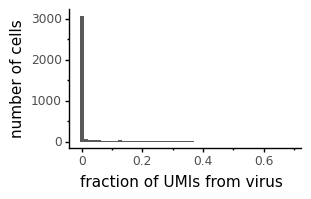

In [18]:
p = (ggplot(adata.obs.query('not filtered'), aes('viral_UMI_frac')) +
     geom_histogram(bins=50) +
     theme(figure_size=(3, 1.8)) +
     xlab('fraction of UMIs from virus') +
     ylab('number of cells')
     )
_ = p.draw()

### Fraction of cells infected
Want a simple estimate of what proportion of all filtered cells are infected. For now, I will simply use a cutoff of >=1% of UMIs come from viral genes.

In [19]:
single_cells = len(adata.obs.query('(not filtered)'))
infected_cells = len(adata.obs.query('(not filtered) & (viral_UMI_frac > 0.01)'))
frac_infected = infected_cells / single_cells * 100

print(f"The total number of single cells is: {single_cells} cells.")
print(f"Of these, {infected_cells} are likely bona fide infected cells. These droplets derive at least 1% of their UMIs from viral genes.")
print(f"This is {frac_infected:.1f}% of cells in the dataset.")

The total number of single cells is: 3581 cells.
Of these, 496 are likely bona fide infected cells. These droplets derive at least 1% of their UMIs from viral genes.
This is 13.9% of cells in the dataset.


I will make a plot of these cells showing the fraction of UMI from virus in each.

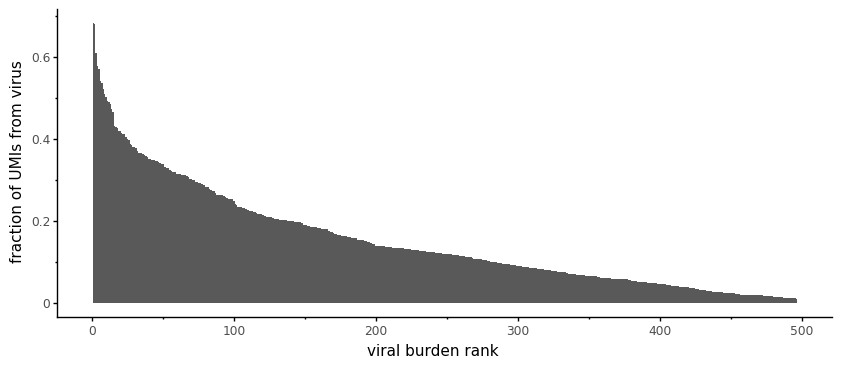

In [20]:
working_df = adata.obs.query('(not filtered) & (viral_UMI_frac > 0.01)')
working_df = working_df.sort_values(by=['viral_UMI_frac'], ascending=False)
working_df['viral_UMI_frac_rank'] = working_df.reset_index().index + 1

p = (ggplot(working_df, 
            aes(x='viral_UMI_frac_rank', y='viral_UMI_frac')) +
     geom_bar(stat='identity', width=1) +
     theme(figure_size=(10, 4)) +
     xlab('viral burden rank') +
     ylab('fraction of UMIs from virus')
     )
_ = p.draw()

### Fraction of cells with high viral burden
What proportion of cells have a high proportion of viral UMIs? Say, 10% of UMIs from virus?

In [21]:
high_virus_cells = adata.obs.query('(viral_UMI_frac > 0.1) & (not filtered)')
n_high_virus_cells = len(high_virus_cells)

print(f"There are {n_high_virus_cells} cells that passed filtering with a high viral burden (more than 10% of UMIs come from virus).")
print(f"This represents {n_high_virus_cells/infected_cells*100:.1f}% of infected cells and {n_high_virus_cells/single_cells*100:.1f}% of all cells in the datset.")
print(f"In these cells, the average proportion of UMIs from virus is: {high_virus_cells['viral_UMI_frac'].mean():.3f}")

There are 283 cells that passed filtering with a high viral burden (more than 10% of UMIs come from virus).
This represents 57.1% of infected cells and 7.9% of all cells in the datset.
In these cells, the average proportion of UMIs from virus is: 0.230


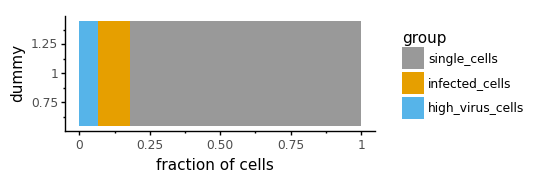

In [22]:
working_df = pd.DataFrame({'group':['single_cells','infected_cells','high_virus_cells'],
                           'n_cells':[f'{single_cells}',f'{infected_cells}',f'{n_high_virus_cells}'],
                           'dummy':[1,1,1]
                          })
cat_dtype = pd.api.types.CategoricalDtype(
    categories=working_df['group'], ordered=True)
working_df['group'] = working_df['group'].astype(cat_dtype)
working_df['n_cells'] = working_df['n_cells'].astype(float)
working_df['frac_cells'] = working_df['n_cells'] / float(working_df.query('group == "single_cells"')['n_cells'])


p = (ggplot(working_df, 
            aes(x='dummy', y='frac_cells', fill='group')) +
     geom_bar(stat='identity', position='fill') +
     coord_flip() +
     theme(figure_size=(4, 1.5)) +
     ylab('fraction of cells') +
     scale_fill_manual(cbpalette[0:])
     )
_ = p.draw()

## Parsing Viral Tags

### Variant infecting each cell -- unfiltered cell barcodes
I'd like to label each cell as being infected by WT or dblSyn virus. I expect some leakage of transcripts from droplet to droplet, so there may be a few reads of the opposite type. Overall, I expect most cells which are truly infected will have the vast majority of their reads from one variant or the other.

#### Loading tag counts
A lot of cell barcodes have no value for either the WT tag count or the dblSyn tag count, or both. To deal with this, **I will add replace these values with 0 right away.** This solves an error that was previously introduced, where any cell with an `NaN` value for either variant could not be processed correctly.

#### Cutoffs for purity
I will call cell as infected by either WT or dblSyn variant of virus, based on ratio of tag counts. I made arbitrary cutoffs using 0.3 and .7 as the ratios. These are at least reciprocal. I will interpret any ratio between these cutoffs is mixed.

In [23]:
# Load counts of each viral tag from `viraltag_counts.csv`
print(f"Reading viral tag counts from {input_viraltag_counts}")
tag_counts_df = pd.read_csv(input_viraltag_counts)

tag_counts_df = tag_counts_df.rename(columns={'cell_barcode':'cell_barcodes'})

tag_counts_df = tag_counts_df.groupby(['cell_barcodes','tag_variant']).sum()
tag_counts_df = tag_counts_df.reset_index(level=['cell_barcodes','tag_variant'])
tag_counts_df = tag_counts_df.pivot_table('count', ['cell_barcodes'], 'tag_variant')
tag_counts_df = tag_counts_df.fillna(0)

Reading viral tag counts from results/viral_fastq10x/viraltag_counts_hashing_trial2.csv


In [24]:
tag_counts_df.loc[tag_counts_df['wt'] > tag_counts_df['syn'], 'major_species'] = 'wt'
tag_counts_df.loc[tag_counts_df['wt'] < tag_counts_df['syn'], 'major_species'] = 'syn'
tag_counts_df.loc[tag_counts_df['wt'] == tag_counts_df['syn'], 'major_species'] = 'mixed'

In [25]:
fraction_cutoff = 0.7 #Set a 30% contamination fraction as the cutoff for mixed calls.

tag_counts_df['total_tags'] = (tag_counts_df['syn'] + tag_counts_df['wt'])

tag_counts_df.loc[tag_counts_df['major_species'] == 'wt', 'major_species_frac'] = tag_counts_df['wt'] / tag_counts_df['total_tags']
tag_counts_df.loc[tag_counts_df['major_species'] == 'syn', 'major_species_frac'] = tag_counts_df['syn'] / tag_counts_df['total_tags']
tag_counts_df.loc[tag_counts_df['major_species'] == 'mixed', 'major_species_frac'] = tag_counts_df['wt'] / tag_counts_df['total_tags']

tag_counts_df['variant'] = 'mixed'

tag_counts_df.loc[tag_counts_df['major_species_frac'] > fraction_cutoff, 'variant'] = tag_counts_df['major_species']
tag_counts_df.loc[tag_counts_df['total_tags'] == 0, 'variant'] = 'no tags'
tag_counts_df = tag_counts_df.reset_index()
tag_counts_df = tag_counts_df.sort_values(by=['major_species_frac'], ascending=False)
tag_counts_df['major_species_frac_rank'] = tag_counts_df.reset_index().index + 1

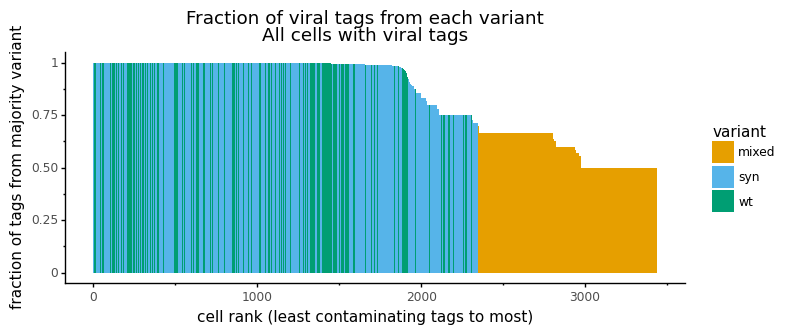

In [26]:
p = (ggplot(tag_counts_df, 
            aes(x='major_species_frac_rank', y='major_species_frac', fill='variant')) +
     geom_bar(stat='identity', width=1) +
     theme(figure_size=(8, 3)) +
     ggtitle('Fraction of viral tags from each variant\nAll cells with viral tags') +
     xlab('cell rank (least contaminating tags to most)') +
     ylab('fraction of tags from majority variant') +
     scale_fill_manual(values=cbpalette[1:])
     )
_ = p.draw()

### Variant infecting cells called as "infected"
Now, I will take the tag count and variant identity information I just calculated and merge it with the infection status information I calculated above. This will give the variant call for each "true" infected cell.

In [27]:
adata.obs = adata.obs.merge(tag_counts_df, on='cell_barcodes', how='outer')
adata.obs

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


,cell_barcodes,total_UMIs,viral_UMIs,cellular_UMIs,viral_UMI_frac,filtered,filtered_desc,syn,wt,major_species,total_tags,major_species_frac,variant,major_species_frac_rank
0,AAACCCAAGGTCGAGT,8897.0,3.0,8894.0,0.000337,False,retained,2.0,0.0,syn,2.0,1.000000,syn,1.0
1,AAACCCACAAAGAACT,8449.0,11.0,8438.0,0.001302,False,retained,7.0,2.0,syn,9.0,0.777778,syn,2106.0
2,AAACCCAGTACTGGGA,2982.0,2.0,2980.0,0.000671,True,too few cellular UMIs,0.0,1.0,wt,1.0,1.000000,wt,1162.0
3,AAACCCATCCCTCAAC,10218.0,2.0,10216.0,0.000196,False,retained,1.0,1.0,mixed,2.0,0.500000,mixed,3119.0
4,AAACCCATCGAGCCTG,8720.0,2.0,8718.0,0.000229,False,retained,1.0,0.0,syn,1.0,1.000000,syn,1234.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3732,TTTGTTGCAAACTAGA,13946.0,843.0,13103.0,0.060447,False,retained,577.0,4.0,syn,581.0,0.993115,syn,1543.0
3733,TTTGTTGGTCATCGGC,8568.0,14.0,8554.0,0.001634,False,retained,5.0,1.0,syn,6.0,0.833333,syn,2014.0
3734,TTTGTTGGTTTGCAGT,8394.0,4.0,8390.0,0.000477,False,retained,0.0,3.0,wt,3.0,1.000000,wt,1109.0
3735,TTTGTTGTCCGCACGA,3210.0,915.0,2295.0,0.285047,True,too few cellular UMIs,0.0,625.0,wt,625.0,1.000000,wt,1229.0


In [28]:
single_cells = len(adata.obs.query('(not filtered)'))
    
print(f"The total number of retained single cells is: {single_cells} cells.")
print(f"I assume half of these ({single_cells/2:.0f} cells) were from the well infected",
      "with WT virus and half were from the well infected with dblSyn.\n")

for var in ['wt','syn', 'mixed', 'no tags']:
    var_infected_cells = len(adata.obs.query('(not filtered) & (viral_UMI_frac > 0.01) & (variant == @var)'))
    var_frac_infected = var_infected_cells / (single_cells / 2) * 100

    if var == 'wt' or var == 'syn':
        print(f"There were {var_infected_cells} cells called as infected with {var} virus.")
        print(f"Assuming half the total single cells came from this sample well, {var_frac_infected:.0f}% of the cells in that well were infected.\n")
    else:
        print(f"There were {var_infected_cells} droplets called as {var}.")
    

The total number of retained single cells is: 3581 cells.
I assume half of these (1790 cells) were from the well infected with WT virus and half were from the well infected with dblSyn.

There were 216 cells called as infected with wt virus.
Assuming half the total single cells came from this sample well, 12% of the cells in that well were infected.

There were 277 cells called as infected with syn virus.
Assuming half the total single cells came from this sample well, 15% of the cells in that well were infected.

There were 3 droplets called as mixed.
There were 0 droplets called as no tags.


Plot the proportions of tag counts for each true infected cell.

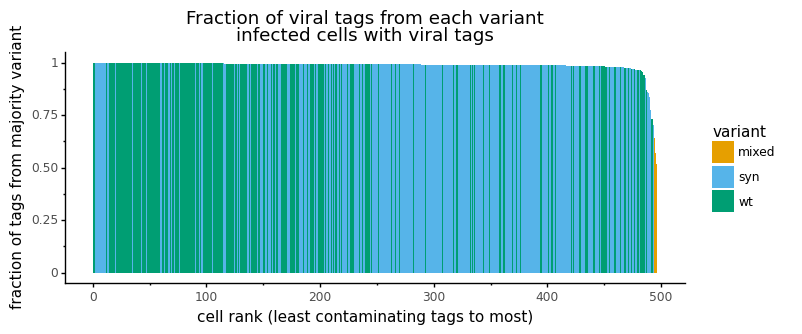

In [29]:
working_df = adata.obs.query('(not filtered) & (viral_UMI_frac > 0.01)')
working_df = working_df.sort_values(by=['major_species_frac'], ascending=False)
working_df['major_species_frac_rank'] = working_df.reset_index().index + 1
p = (ggplot(working_df, 
            aes(x='major_species_frac_rank', y='major_species_frac', fill='variant')) +
     geom_bar(stat='identity', width=1) +
     theme(figure_size=(8, 3)) +
     ggtitle('Fraction of viral tags from each variant\ninfected cells with viral tags') +
     xlab('cell rank (least contaminating tags to most)') +
     ylab('fraction of tags from majority variant') +
     scale_fill_manual(values=cbpalette[1:])
     )
_ = p.draw()

## Parsing viral barcodes
I would like to know how many virions infected each cell in this dataset.

#### Loading barcodes
The barcodes are parsed in the `count_viralbc_fastq10x` notebook. This, in turn, calls the `extract_tags` functions to identify reads that align and cover the position of the viral barcode in the reference genome. The barcodes are checked for quality and then exported.

I will import the barcode counts from the `viralbc_counts` CSV. This file lists the counts for each cell/segment/viral barcode combination.

#### Counting viral barcodes per cell -- unfiltered cell barcodes
For each cell, I will count the number of "true" viral barcodes that are present for each segment. I have a few naiive assumptions:
* If capture is good for both segments, I expect the number of barcodes on HA to (usually) match the number of barcodes on NA.
* At a rate of ~20% of cells infected, assuming poisson occupancy, I expect ~18% of cells to have only 1 viral barcode, and about 2% of cells to have >1 viral barcodes.
* These cells were infected in a large dish with a large viral innoculum. With the diversity of the viral barcodes in the viral stock, it is likely that the same barcode will show up in multiple cells.

I will define "true" barcodes as barcodes that are seen in more than X UMI for a given cell/segment combination. The counts for these data are generally quite low right now. Jesse shared the advice that at low counts, using integers of counts is a better method than percentages. This makes sense given that a single count is a large percentage of these data. To see how filtering varies with cutoff choice, I will test a few different cutoffs and plot them side by side.

In [30]:
# Load counts of each viral barcode from `viraltag_counts.csv`
print(f"Reading viral barcode counts from {input_viralbc_counts}")
bc_counts_df = pd.read_csv(input_viralbc_counts)

bc_counts_df = bc_counts_df.rename(columns={'cell_barcode':'cell_barcodes'})

print(bc_counts_df.head())
#print(bc_counts_df.size)

Reading viral barcode counts from results/viral_fastq10x/viralbc_counts_hashing_trial2.csv
    gene     cell_barcodes     viral_barcode  count
0  fluHA  AAACGAAGTAGTGATA  AACGGATTCCCTAAAA      1
1  fluHA  AAACGAAGTAGTGATA  CGTGGATCACAGAAAA      1
2  fluHA  AAACGAAGTAGTGATA  TCTACTGTACTGTGTT      1
3  fluHA  AAACGAAGTAGTGATA  TTTCGGTTGATTATTG      1
4  fluHA  AAACGAATCATAGAGA  CCGTCCTGAGTTCCGG     14


First, I will filter this data by a variety of cutoffs. I will append each filter result to the dataframe.

In [31]:
cutoffs = [2,3,5,10]

working_df = bc_counts_df.copy(deep=True)
for cutoff in cutoffs:

    print(f"Marking as filtered if less than {cutoff:.0f} UMIs for a given barcode in a cell.")

    working_df['cutoff'] = cutoff
    working_df['filtered'] = working_df['count'] < cutoff
    #print(working_df.head())
    
    bc_counts_df = bc_counts_df.append(working_df)
    
bc_counts_df['cutoff'] = bc_counts_df['cutoff'].fillna(0)
bc_counts_df['filtered'] = bc_counts_df['filtered'].fillna(False)

bc_counts_df = bc_counts_df.reset_index()
bc_counts_df = bc_counts_df.drop(labels=['index'],axis=1)

#print(bc_counts_df.size)

Marking as filtered if less than 2 UMIs for a given barcode in a cell.
Marking as filtered if less than 3 UMIs for a given barcode in a cell.
Marking as filtered if less than 5 UMIs for a given barcode in a cell.
Marking as filtered if less than 10 UMIs for a given barcode in a cell.


In [32]:
bc_counts_df.head()

,cell_barcodes,count,cutoff,filtered,gene,viral_barcode
0,AAACGAAGTAGTGATA,1,0.0,False,fluHA,AACGGATTCCCTAAAA
1,AAACGAAGTAGTGATA,1,0.0,False,fluHA,CGTGGATCACAGAAAA
2,AAACGAAGTAGTGATA,1,0.0,False,fluHA,TCTACTGTACTGTGTT
3,AAACGAAGTAGTGATA,1,0.0,False,fluHA,TTTCGGTTGATTATTG
4,AAACGAATCATAGAGA,14,0.0,False,fluHA,CCGTCCTGAGTTCCGG


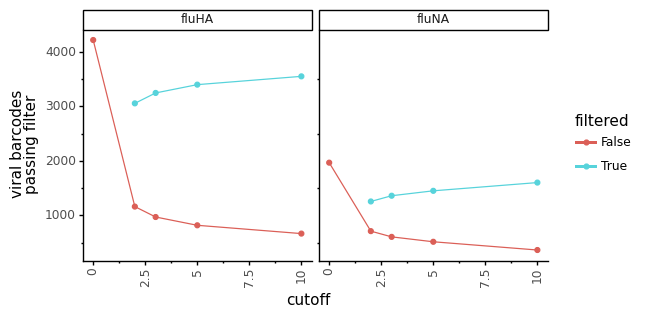

In [33]:
p = (ggplot(bc_counts_df, aes('cutoff', color='filtered')) +
     geom_point(stat='count') +
     geom_line(stat='count') +
     facet_wrap('~gene') +
     theme(figure_size=(6, 3),
           axis_text_x=element_text(angle=90)) +
     scale_y_continuous() +
     ylab('viral barcodes\npassing filter')
     )

_ = p.draw()

Then, I will count the number of unique viral barcodes associated with each cell barcode-gene combination:

In [34]:
viralbc_per_cell_df = bc_counts_df[bc_counts_df['filtered'] == False].groupby(['cell_barcodes','gene','cutoff']).count()
viralbc_per_cell_df =  viralbc_per_cell_df.reset_index(level=['cell_barcodes','gene','cutoff'])
viralbc_per_cell_df = viralbc_per_cell_df.drop(labels=['count','filtered'],axis=1)
viralbc_per_cell_df = viralbc_per_cell_df.rename(columns={'viral_barcode':'n_viralbc'})
viralbc_per_cell_df['n_viralbc'] = viralbc_per_cell_df['n_viralbc'].astype(int)
viralbc_per_cell_df.head()

,cell_barcodes,gene,cutoff,n_viralbc
0,AAACGAAGTAGTGATA,fluHA,0.0,4
1,AAACGAATCATAGAGA,fluHA,0.0,2
2,AAACGAATCATAGAGA,fluHA,2.0,1
3,AAACGAATCATAGAGA,fluHA,3.0,1
4,AAACGAATCATAGAGA,fluHA,5.0,1


Then, I'll examine the distributions of cell barcodes per cell. Want to find a cutoff range that is fairly stable and does not change the distribtuion much.

/fh/fast/bloom_j/software/conda_v2/envs/BloomLab/lib/python3.6/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_bin : Removed 78 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


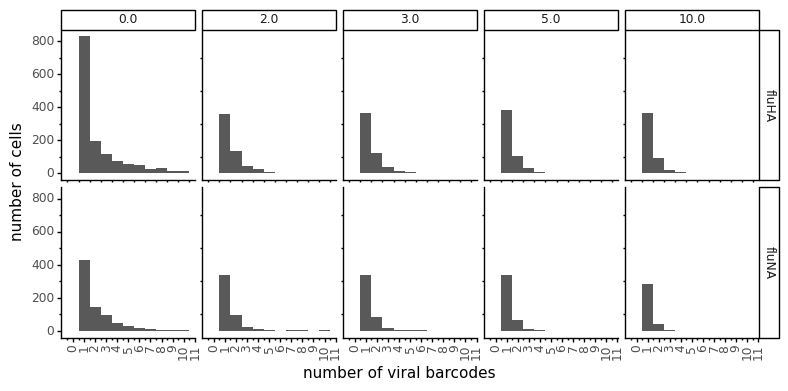

In [35]:
p = (ggplot(viralbc_per_cell_df, aes('n_viralbc')) +
     geom_histogram(binwidth=1) +
     facet_grid('gene~cutoff') +
     scale_x_continuous(breaks=list(range(0,36)), limits = [-0.5,10.5]) +
     theme(figure_size=(9, 4),
           axis_text_x=element_text(angle=90)) +
     ylab('number of cells') +
     xlab('number of viral barcodes')
     )

_ = p.draw()

In [36]:
max(viralbc_per_cell_df['n_viralbc'])

108

ggplot throws an error for "non-finite values". This is because some cells are counted as having up to 36 viral barcodes, and that is outside the limits of the plot. That is fine -- they are probably not real, and there are so few cells in this range that they cannot be visualized anyway.

### Choosing an empirical cutoff for viral barcode UMI counts
Based on the plots above, filtering is somewhat stable using a cutoff in the range `3-10`. No filtering produces a lot of cell which are called as having `>2` virions infecting. The number of filtered barcodes changes rather dramatically by changing the cutoff from `2` to `3`, but the number of virions infecting each cell histogram does not change much. Converseley, the number of filtered barcodes does not change much  from `3` to `10`.

**For this first pass, I will choose a cutoff of `3`. It is an intermediate filtering plot and histogram that looks pretty similar to 5, but yields more total cells and more co-infected cells.**

In [37]:
cutoff_choice = 3

viralbc_per_cell_df = viralbc_per_cell_df[viralbc_per_cell_df['cutoff'] == cutoff_choice]
#viralbc_per_cell_df.head()

In [38]:
viralbc_per_cell_df = viralbc_per_cell_df.pivot_table(index='cell_barcodes', columns='gene', values='n_viralbc')
viralbc_per_cell_df = viralbc_per_cell_df.rename(columns={'fluHA':'ha_n_viralbc', 'fluNA':'na_n_viralbc'})
viralbc_per_cell_df.head()

gene,ha_n_viralbc,na_n_viralbc
cell_barcodes,,
AAACGAATCATAGAGA,1.0,2.0
AAAGAACCACACGGTC,1.0,5.0
AAAGAACCACTTGACA,1.0,1.0
AAAGGATAGTCGTTAC,2.0,1.0
AAAGGTAGTGGATCAG,1.0,NaN


### Viral barcode count for cells called as infected
Now, I will take the viral barcode count information I just calculated and merge it with the infection status information I calculated above. This will give the variant call for each "true" infected cell.

**N.b.** Many cells have `NaN` values for one (or both) of the barcoded segments. These represent cells where a barcode was either not picked up or did not pass the filtering above. I could fill these in with `0`, which would make downstream plotting easier. However, putting a value on this is a bit less representative, so for now, I will leave them as `NaN`.

In [39]:
adata.obs = adata.obs.merge(viralbc_per_cell_df, on='cell_barcodes', how='outer')
adata.obs.query('(not filtered) & (viral_UMI_frac > 0.01)').head()

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


,cell_barcodes,total_UMIs,viral_UMIs,cellular_UMIs,viral_UMI_frac,filtered,filtered_desc,syn,wt,major_species,total_tags,major_species_frac,variant,major_species_frac_rank,ha_n_viralbc,na_n_viralbc
9,AAACGAATCATAGAGA,8976.0,1234.0,7742.0,0.137478,False,retained,812.0,5.0,syn,817.0,0.993880,syn,1506.0,1.0,2.0
16,AAAGAACCACACGGTC,8333.0,3030.0,5303.0,0.363615,False,retained,1726.0,17.0,syn,1743.0,0.990247,syn,1666.0,1.0,5.0
17,AAAGAACCACTTGACA,12785.0,1118.0,11667.0,0.087446,False,retained,5.0,754.0,wt,759.0,0.993412,wt,1526.0,1.0,1.0
23,AAAGGATAGTCGTTAC,7642.0,989.0,6653.0,0.129416,False,retained,646.0,7.0,syn,653.0,0.989280,syn,1710.0,2.0,1.0
33,AAAGGTAGTGGATCAG,15869.0,651.0,15218.0,0.041023,False,retained,435.0,8.0,syn,443.0,0.981941,syn,1859.0,1.0,NaN


In [40]:
max_ha_n_viralbc = int(adata.obs.query('(not filtered)')['ha_n_viralbc'].max())
    
print(f"The total number of retained single cells is: {single_cells} cells.")
print(f"The total number of infected  cells is: {infected_cells} cells.")
print(f"The fraction of infected  cells is: {frac_infected:.1f}% of cells.")
                       
print(f"\nThe highest number of viral barcodes found in a true infected cell is {max_ha_n_viralbc} viral barcodes.\n")


# cells_with_x_virions = len(adata.obs.query('(not filtered) & (viral_UMI_frac > 0.01) & (ha_n_viralbc.isnull())', engine='python'))
# frac_x_virions = cells_with_x_virions / (single_cells) * 100
# print(f"There are {cells_with_x_virions} true infected cells that could not have any viral barcodes called.")
# print(f"This is {frac_x_virions:.1f}% of all cells in the dataset.\n")

# for x in range(1, max_ha_n_viralbc+1):
#     cells_with_x_virions = len(adata.obs.query(f'(not filtered) & (viral_UMI_frac > 0.01) & (ha_n_viralbc == {x})'))
#     frac_x_virions = cells_with_x_virions / (single_cells) * 100
#     print(f"There are {cells_with_x_virions} true infected cells with {x} viral barcodes present in the HA segment of that cell.")
#     print(f"This is {frac_x_virions:.1f}% of all (infected and unifected) cells in the dataset.\n")
    

The total number of retained single cells is: 3581 cells.
The total number of infected  cells is: 496 cells.
The fraction of infected  cells is: 13.9% of cells.

The highest number of viral barcodes found in a true infected cell is 29 viral barcodes.



#### Plot viral barcode distributions in infected cells
Now I would like to plot the viral barcodes a few ways.
* First, I would like to compare HA and NA viral barcode distributions.
* Second, I would like to compare HA and NA viral barcode counts within each cell.
* Third, I would like to compare the number of distribution of viral barcodes in these data to the expectation of viral barcode counts under an assumption of poisson occupancy.



/fh/fast/bloom_j/software/conda_v2/envs/BloomLab/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/fh/fast/bloom_j/software/conda_v2/envs/BloomLab/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/fh/fast/bloom_j/software/conda_v2/envs/BloomLab/lib/python3.6/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_bin : Removed 10 rows containing non-finite values.
  data = self.stat.compute_layer(data, 

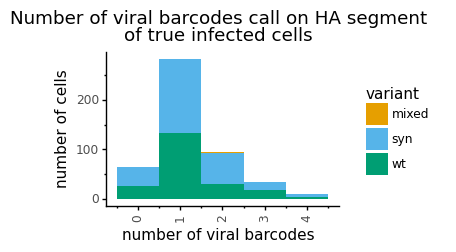

In [41]:
# I should really melt this dataframe so that I can facet this plot, rather than doing it twice.
# The melt syntax is tripping me up, so for now I'm just going to do it by hand.

working_df = adata.obs.query('(not filtered) & (viral_UMI_frac > 0.01)')
working_df['ha_n_viralbc'] = working_df['ha_n_viralbc'].fillna(0)
working_df['na_n_viralbc'] = working_df['na_n_viralbc'].fillna(0)

p = (ggplot(working_df, aes('ha_n_viralbc', fill='variant')) +
     geom_histogram(binwidth=1) +
     scale_x_continuous(breaks=list(range(0,5)), limits=[-.5,4.5]) +
     theme(figure_size=(3, 2),
           axis_text_x=element_text(angle=90)) +
     ggtitle('Number of viral barcodes call on HA segment\nof true infected cells') +
     ylab('number of cells') +
     xlab('number of viral barcodes') +
     scale_fill_manual(values=cbpalette[1:])
     )

_ = p.draw()

/fh/fast/bloom_j/software/conda_v2/envs/BloomLab/lib/python3.6/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_bin : Removed 5 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


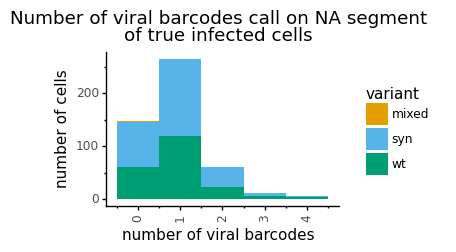

In [42]:
p = (ggplot(working_df, aes('na_n_viralbc', fill='variant')) +
     geom_histogram(binwidth=1) +
     scale_x_continuous(breaks=list(range(0,5)), limits=[-.5,4.5]) +
     theme(figure_size=(3, 2),
           axis_text_x=element_text(angle=90)) +
     ggtitle('Number of viral barcodes call on NA segment\nof true infected cells') +
     ylab('number of cells') +
     xlab('number of viral barcodes') +
     scale_fill_manual(values=cbpalette[1:])
     )

_ = p.draw()

/fh/fast/bloom_j/software/conda_v2/envs/BloomLab/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_jitter : Removed 15 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


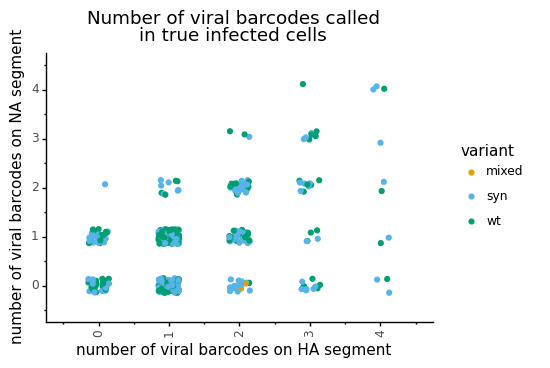

In [43]:
p = (ggplot(working_df, aes(x='ha_n_viralbc', y='na_n_viralbc', color='variant')) +
     geom_jitter(width=0.15, height=0.15) +
     theme(figure_size=(5, 3.5),
           axis_text_x=element_text(angle=90)) +
     scale_x_continuous(breaks=list(range(0,5)), limits=[-.5,4.5]) +
     scale_y_continuous(breaks=list(range(0,5)), limits=[-.5,4.5]) +
     ggtitle('Number of viral barcodes called\nin true infected cells') +
     xlab('number of viral barcodes on HA segment') +
     ylab('number of viral barcodes on NA segment') +
     scale_color_manual(values=cbpalette[1:])
     )

_ = p.draw()

#### Do barcode distributions fit a Poisson model?
I'd like to compare the distribution of barcode counts to a null of model. Assuming poisson occupancy of virus in cells, given the overall infection rate, how many cells would we expect to have 0 viral barcodes, 1 viral barcodes, 2 viral barcodes, etc...

**Calculating mu from observed number of infected cells**

Our `frac_infected` variable gives the number of cells that we have called as infected. This includes cells that were infected by a single virion `(k=1)`, as well as cells that were infected by any other number of virions `(k>=1)`. At low MOI, this value is very close to the average MOI (called `poisson_u` in my code below). However, at higher MOI, these values deviate substantially, as more and more cells are infected by multiple virions.

To calculate the MOI, or average number of virions per cell, of the observed data, I will work backwards from the poisson formula. 

```
P(k=poisson_k|poisson_u) = (numpy.e**(-1*poisson_u)) * (poisson_u**poisson_k) / math.factorial(poisson_k)

```

Thankfully, working with a distinction between 0 and 1 simplifies the math quite a bit:

```
P(k>=1|poisson_u) = frac_infected
P(k=0|poisson_u) = 1 - P(k>=1|poisson_u)
frac_not_infected = 1 - frac_infected

frac_not_infected = P(k=0|poisson_u) = (numpy.e**(-1*poisson_u)) * (poisson_u**0) / math.factorial(0)

(poisson_u**0) = 1
math.factorial(0) = 1

frac_not_infected = numpy.e**(-1*poisson_u)
math.log(frac_not_infected) = -1*poisson_u
poisson_u = -1 * math.log(frac_not_infected).
```

The average of the poisson distribution (or MOI) is simply the `-log` of `1 - the fraction infected` (observed).

In [44]:
# Calculate poisson expectation
poisson_expectation = list()

for k in range(0, max_ha_n_viralbc+1):

    poisson_k = k
    frac_not_infected = 1 - frac_infected/100
    poisson_u = -1 * math.log(frac_not_infected)
            
#     print("Calculating poisson probabilities of viral barcode counts with:\n",
#          f"Poisson random variable X = {poisson_k}\n",
#          f"Infection rate = {frac_infected/100:.3f};\t",
#          f"Poisson u = {poisson_u:0.3f}")

    r = poisson.pmf(k=poisson_k, mu=poisson_u)
#     print(f" The expected proportion of cells with {poisson_k} viral barcodes is {r:.2f}.")
#     print(f" This is {r*single_cells:.0f} of all {single_cells} cells in the dataset.\n")
    
    poisson_expectation.append({'n_viralbc':poisson_k,
                                'n_cells': int(r*single_cells),
                               })

poisson_expectation = pd.DataFrame(poisson_expectation)
poisson_expectation['gene'] = 'poisson model'

In [45]:
# p = (ggplot(poisson_expectation, aes(x='n_viralbc', y='n_cells')) +
#      geom_bar(stat='identity') +
#      scale_x_continuous(limits=[-0.5,4.5]) +
#      theme(figure_size=(5, 3.5),
#            axis_text_x=element_text(angle=90)) +
#      ggtitle('Numnber of viral barcodes expected\nunder Poisson model') +
#      ylab('number of cells') +
#      xlab('number of viral barcodes') +
#      annotate('text', x=4, y= 2800, label=f'MOI = {poisson_u:.3f}')
#      )

# _ = p.draw()

In [46]:
#Calculate distribution of viral barcodes per cell for each gene in observed data
cells_df = adata.obs.query('(not filtered)')

working_df = pd.DataFrame()

for g in ['ha', 'na']:
    gene_df = pd.DataFrame()
    gene_df['n_cells'] = cells_df[f'{g}_n_viralbc'].value_counts(dropna=False)
    gene_df['gene'] = g
    working_df = working_df.append(gene_df)
    #print(working_df)
    
working_df = working_df.reset_index().rename(columns={'index': 'n_viralbc'})

working_df = working_df.append(poisson_expectation)
working_df = working_df.fillna(0)

#working_df.head()

Finally, plot the observed distribuiont of viral barcodes per cell for each gene alongside the poisson expectation, given the fraction of cells called as infected.

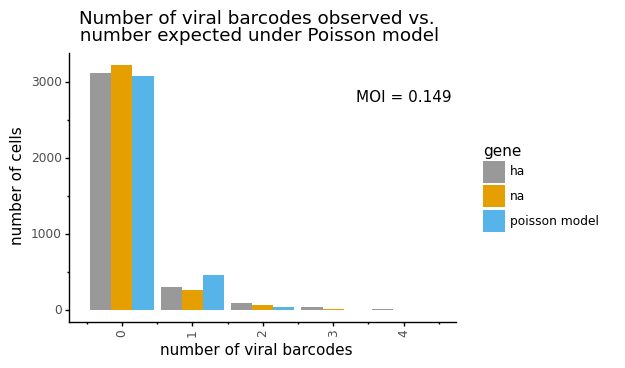

In [47]:
p = (ggplot(working_df, aes(x='n_viralbc', y='n_cells', fill='gene')) +
     geom_bar(stat='identity', position='dodge') +
     scale_x_continuous(limits=[-0.5,4.5]) +
     theme(figure_size=(5, 3.5),
           axis_text_x=element_text(angle=90)) +
     ggtitle('Number of viral barcodes observed vs.\n number expected under Poisson model') +
     ylab('number of cells') +
     xlab('number of viral barcodes') +
     annotate('text', x=4, y= 2800, label=f'MOI = {poisson_u:.3f}') +
     scale_fill_manual(values=cbpalette[0:])
     )

_ = p.draw()

### How are viral barcodes shared across cells?
I see that most cells have 0 or 1 viral barcodes. Are most viral barcodes only found in 1 cell?

#### Viral barcode sharing in all cells -- unfiltered
First, I will calculate the distribution for the raw data -- all barcode counts, filtered by various cutoffs.

In [48]:
cells_per_viralbc_df = bc_counts_df[bc_counts_df['filtered'] == False].groupby(['viral_barcode','gene','cutoff']).count()
cells_per_viralbc_df =  cells_per_viralbc_df.reset_index(level=['viral_barcode','gene','cutoff'])
cells_per_viralbc_df = cells_per_viralbc_df.drop(labels=['count','filtered'],axis=1)
cells_per_viralbc_df = cells_per_viralbc_df.rename(columns={'cell_barcodes':'n_cells'})
cells_per_viralbc_df['n_cells'] = cells_per_viralbc_df['n_cells'].astype(int)
cells_per_viralbc_df.head()

,viral_barcode,gene,cutoff,n_cells
0,AAAAAAAGTATTCTCT,fluHA,0.0,1
1,AAAAAAAGTATTCTCT,fluHA,2.0,1
2,AAAAAAAGTATTCTCT,fluHA,3.0,1
3,AAAAAAAGTTTCAAGG,fluHA,0.0,1
4,AAAAAAAGTTTCAAGG,fluHA,2.0,1


In [49]:
#What is the maximum number of cells a viral barcode is found in (Raw Counts Data)?
cells_per_viralbc_df['n_cells'].max()

210

/fh/fast/bloom_j/software/conda_v2/envs/BloomLab/lib/python3.6/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_bin : Removed 15 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


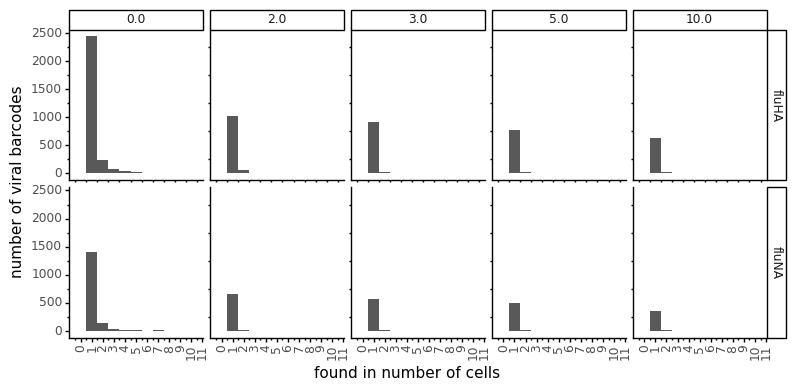

In [50]:
p = (ggplot(cells_per_viralbc_df, aes('n_cells')) +
     geom_histogram(binwidth=1) +
     facet_grid('gene~cutoff') +
     scale_x_continuous(breaks=list(range(0,36)), limits = [-0.5,10.5]) +
     theme(figure_size=(9, 4),
           axis_text_x=element_text(angle=90)) +
     ylab('number of viral barcodes') +
     xlab('found in number of cells')
     )

_ = p.draw()

#### Viral barcode sharing in true infected cells
Next, I will add these data to the adata.obs dataframe and see how many of the infected cells I am analyzing in this dataset share viral barcodes with another cell.

In [51]:
#Merge raw bc counts, as I need cell barcode information, viral barcode information, and gene information.
#These are note present in above summary dataframes.

working_df = bc_counts_df.copy()
working_df = working_df.query(f'(not filtered) & (cutoff == {cutoff_choice})')
working_df = working_df.drop(labels=['count','cutoff','filtered'], axis=1)

working_df = working_df.merge(adata.obs, on='cell_barcodes', how='outer')
working_df = working_df.query('(not filtered) & (viral_UMI_frac > 0.01)')

working_df.head()                 

,cell_barcodes,gene,viral_barcode,total_UMIs,viral_UMIs,cellular_UMIs,viral_UMI_frac,filtered,filtered_desc,syn,wt,major_species,total_tags,major_species_frac,variant,major_species_frac_rank,ha_n_viralbc,na_n_viralbc
0,AAACGAATCATAGAGA,fluHA,CCGTCCTGAGTTCCGG,8976.0,1234.0,7742.0,0.137478,False,retained,812.0,5.0,syn,817.0,0.993880,syn,1506.0,1.0,2.0
1,AAACGAATCATAGAGA,fluNA,GAGTGACAGAGGAAAG,8976.0,1234.0,7742.0,0.137478,False,retained,812.0,5.0,syn,817.0,0.993880,syn,1506.0,1.0,2.0
2,AAACGAATCATAGAGA,fluNA,TGCCGCTTCGTTGGTT,8976.0,1234.0,7742.0,0.137478,False,retained,812.0,5.0,syn,817.0,0.993880,syn,1506.0,1.0,2.0
3,AAAGAACCACACGGTC,fluHA,CATGGCCGGAAAGGAA,8333.0,3030.0,5303.0,0.363615,False,retained,1726.0,17.0,syn,1743.0,0.990247,syn,1666.0,1.0,5.0
4,AAAGAACCACACGGTC,fluNA,CGTTATATTTGTATTG,8333.0,3030.0,5303.0,0.363615,False,retained,1726.0,17.0,syn,1743.0,0.990247,syn,1666.0,1.0,5.0


In [52]:
#Get counts of how many cells are associated with each viral barcode/gene combination.

working_df = working_df.reset_index()
working_df = working_df.drop(labels='index', axis=1)
working_df = working_df.groupby(['viral_barcode','gene']).count()
working_df = working_df.reset_index()
working_df = working_df[['viral_barcode','gene', 'cell_barcodes']]
working_df = working_df.rename(columns = {'cell_barcodes':'n_cells'})
#working_df.head()

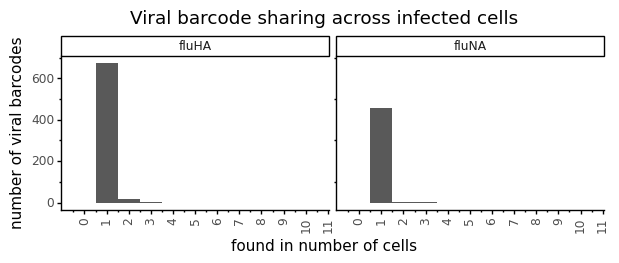

In [53]:
# Plot the results.

p = (ggplot(working_df, aes('n_cells')) +
     geom_histogram(binwidth=1) +
     facet_grid('~gene') +
     scale_x_continuous(breaks=list(range(0,36)), limits = [-0.5,10.5]) +
     theme(figure_size=(7, 2),
           axis_text_x=element_text(angle=90)) +
     ggtitle('Viral barcode sharing across infected cells') +
     ylab('number of viral barcodes') +
     xlab('found in number of cells')
     )

_ = p.draw()

### Single-virion infections and co-infected cells
I will  label cells as uninfected, infected by 1 virion, or infected by more than one virion. My definition for each category is as follows:  
* uninfected (<1% of UMIs from viral reads)
* infected by 1 virion (maximum of 1 viral barcode, when cosidering **both** HA and NA segments)
* infected by >1 virion (>1 viral barcode on **either** HA or NA segment).

Then, I will plot some simple summary statistics to see how they vary by group.

#### Count virions and label cells

In [54]:
def count_virions(row):
    #print(row['ha_n_viralbc'], row['na_n_viralbc'])
    if numpy.isnan(row['ha_n_viralbc']) and numpy.isnan(row['na_n_viralbc']):
        return 0
    elif row['ha_n_viralbc'] > 1 or row['na_n_viralbc'] > 1:
        return max(row['ha_n_viralbc'],row['na_n_viralbc'])
    else:
        return 1

adata.obs['n_virions'] = adata.obs.apply(lambda row: count_virions(row), axis=1)

/fh/fast/bloom_j/software/conda_v2/envs/BloomLab/lib/python3.6/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_bin : Removed 6 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


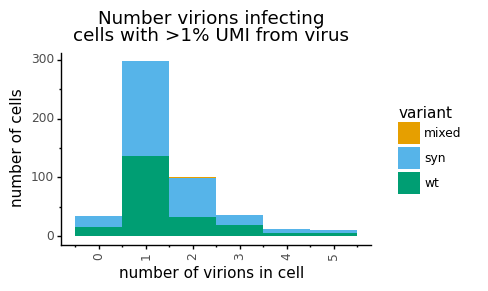

In [55]:
p = (ggplot(adata.obs.query('(not filtered) and (viral_UMI_frac > 0.01)'), aes('n_virions', fill='variant')) +
     geom_histogram(binwidth=1) +
     scale_x_continuous(breaks=list(range(0,6)), limits=[-.5,5.5]) +
     theme(figure_size=(4, 2.5),
           axis_text_x=element_text(angle=90)) +
     ggtitle('Number virions infecting\ncells with >1% UMI from virus') +
     ylab('number of cells') +
     xlab('number of virions in cell') +
     scale_fill_manual(values=cbpalette[1:])
     )

_ = p.draw()

In [56]:
max(adata.obs.query('not filtered')['n_virions'])

29.0

Once again, there is an error thrown because a few cells with high numbers of virions are cut off on this plot.

In [57]:
def cell_infection_status(row):
    #print(row['ha_n_viralbc'], row['na_n_viralbc'])
    if row['viral_UMI_frac'] <= 0.01:
        return 'uninfected'
    else:
        if row['n_virions'] == 0:
            return 'no viral bc detected'
        elif row['n_virions'] == 1:
            return 'single virion'
        else:
            return 'co-infected'

adata.obs['infection_status'] = adata.obs.apply(lambda row: cell_infection_status(row), axis=1)
adata.obs['infection_status'] = pd.Categorical(adata.obs['infection_status'], categories = ['uninfected','single virion','co-infected','no viral bc detected'], ordered = True)

In [58]:
#### Number of cells called as singly-infected or co-infected

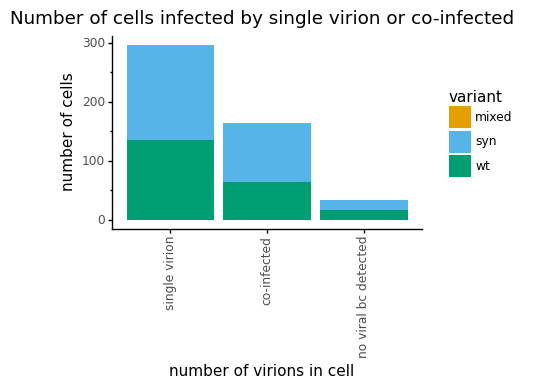

In [59]:
p = (ggplot(adata.obs.query('(not filtered) and (infection_status != "uninfected")'), aes('infection_status', fill='variant')) +
     geom_bar(stat='count') +
     theme(figure_size=(4, 2.5),
           axis_text_x=element_text(angle=90)) +
     ggtitle('Number of cells infected by single virion or co-infected') +
     ylab('number of cells') +
     xlab('number of virions in cell') +
     scale_fill_manual(values=cbpalette[1:])
     )

_ = p.draw()

In [60]:
#### Total UMIs by infection status

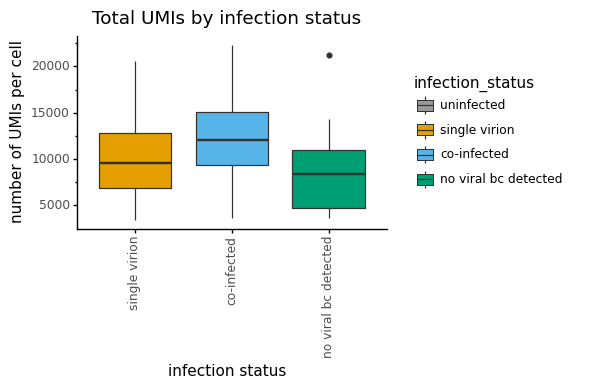

In [61]:
p = (ggplot(adata.obs.query('(not filtered) and (infection_status != "uninfected")'), aes(x='infection_status', y='total_UMIs', fill='infection_status')) +
     geom_boxplot() +
     theme(figure_size=(4, 2.5),
           axis_text_x=element_text(angle=90)) +
     ggtitle('Total UMIs by infection status') +
     ylab('number of UMIs per cell') +
     xlab('infection status') +
     scale_fill_manual(values=cbpalette[0:])
     )

_ = p.draw()

In [62]:
#### Number of viral UMIs by infection status

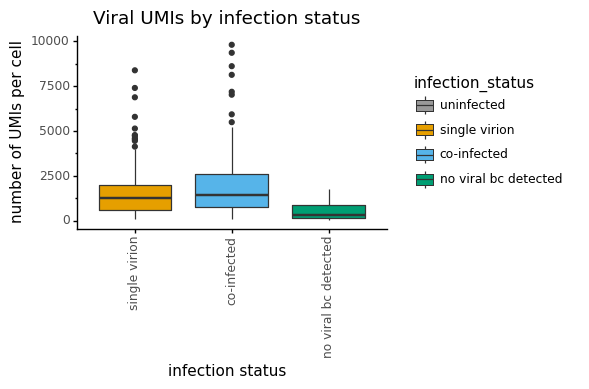

In [63]:
p = (ggplot(adata.obs.query('(not filtered) and (infection_status != "uninfected")'), aes(x='infection_status', y='viral_UMIs', fill='infection_status')) +
     geom_boxplot() +
     theme(figure_size=(4, 2.5),
           axis_text_x=element_text(angle=90)) +
     ggtitle('Viral UMIs by infection status') +
     ylab('number of UMIs per cell') +
     xlab('infection status') +
     scale_fill_manual(values=cbpalette[0:])
     )

_ = p.draw()

#### Fraction of viral UMIs by infection status

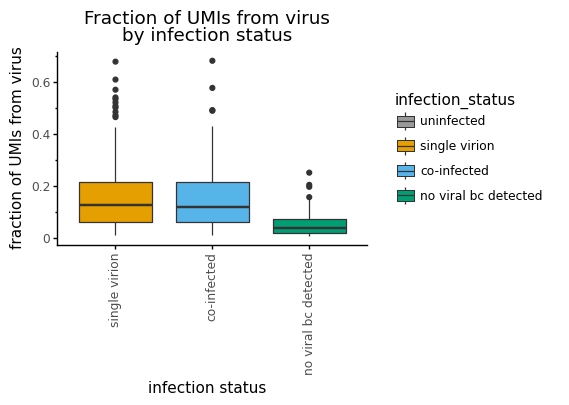

In [64]:
p = (ggplot(adata.obs.query('(not filtered) and (infection_status != "uninfected")'), aes(x='infection_status', y='viral_UMI_frac', fill='infection_status')) +
     geom_boxplot() +
     theme(figure_size=(4, 2.5),
           axis_text_x=element_text(angle=90)) +
     ggtitle('Fraction of UMIs from virus\nby infection status') +
     ylab('fraction of UMIs from virus') +
     xlab('infection status') +
     scale_fill_manual(values=cbpalette[0:])
     )

_ = p.draw()